In [1]:
import pandas as pd
import os
import seaborn
import matplotlib.pyplot as plt 
import numpy as np
import scipy.stats
import statsmodels.api as sm
from scipy import stats
%matplotlib inline

In [3]:
# Load data
Data = pd.read_csv('./Preprocessed Data/Data.csv')
Data.shape

(8722, 26)

In [4]:
# All CCVs Types
CCVStats           = Data.groupby(['CCV', 'bloque', 'TipoNumCCV']).agg(['mean', 'sem'])
CCVStats['block']  = CCVStats.index.get_level_values('bloque')
CCVStats['CCV']    = CCVStats.index.get_level_values('CCV')
CCVStats['type']   = CCVStats.index.get_level_values('TipoNumCCV')

In [5]:
# CCV Types:
#CCVType = 1   #Fricative - Fricative
#CCVType = 2   #Voiced Plosive - Fricative
#CCVType = 3   #Unvoiced Plosive - Fricative
#CCVType = 4   #Fricative - Plosive
CCVType = 5   #Voiced Plosive - Plosive
#CCVType = 6   #Unvoiced Plosive - Plosive

# Voiced Plosive Plosive
Data = Data[Data.TipoNumCCV==CCVType]
Data.shape

(2415, 26)

### Filtering

In [6]:
MaxFFD     = Data.FFD.mean(axis=0) + 2*Data.FFD.std(axis=0)
MinFFD     = Data.FFD.mean(axis=0) - 2*Data.FFD.std(axis=0)
MaxTFT     = Data.TFT.mean(axis=0) + 2*Data.TFT.std(axis=0)
MinTFT     = Data.TFT.mean(axis=0) - 2*Data.TFT.std(axis=0)
MaxFPRT    = Data.FPRT.mean(axis=0)+ 2*Data.FPRT.std(axis=0)
MinFPRT    = Data.FPRT.mean(axis=0)- 2*Data.FPRT.std(axis=0)
OcularData = Data[(Data.FPRT < MaxFPRT) & (Data.FPRT > MinFPRT) & (Data.TFT < MaxTFT) & (Data.TFT > MinTFT) &  (Data.FFD < MaxFFD) & (Data.FFD > MinFFD)]

MaxTN      = OcularData.NormTransition.mean(axis=0) + 2*OcularData.NormTransition.std(axis=0)
MinTN      = OcularData.NormTransition.mean(axis=0) - 2*OcularData.NormTransition.std(axis=0)
OcularData = OcularData[np.logical_or(np.isnan(OcularData.NormTransition), (OcularData.NormTransition < MaxTN) & (OcularData.NormTransition > MinTN))]

StatsOcular           = OcularData.groupby(['CCV', 'bloque', 'TipoNumCCV']).agg(['mean', 'sem'])
StatsOcular['block']  = StatsOcular.index.get_level_values('bloque')
StatsOcular['CCV']    = StatsOcular.index.get_level_values('CCV')
StatsOcular['type']   = StatsOcular.index.get_level_values('TipoNumCCV')

Data.shape
#OcularData.to_csv('DataOcular.csv')

(2415, 26)

### FFD (silent) vs Normalized transition (oral)

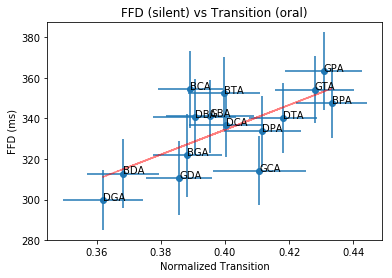

In [7]:
y      = StatsOcular[StatsOcular.block==2].FFD['mean']      # Silent
y_err  = StatsOcular[StatsOcular.block==2].FFD['sem']         
x      = StatsOcular[StatsOcular.block==1].NormTransition['mean']
x_err  = StatsOcular[StatsOcular.block==1].NormTransition['sem']
labels = StatsOcular[StatsOcular.block==1].index.levels[0]

plt.errorbar(x, y, yerr=y_err, xerr=x_err, fmt= 'o')

fit    = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 

plt.plot(x, fit_fn(x), '--r', alpha=0.5)

plt.title('FFD (silent) vs Transition (oral)')
plt.ylabel('FFD (ms)')
plt.xlabel('Normalized Transition')

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))

### One variable Regression --->    Ocular Variable vs Repetition Number. Silent modality

In [111]:
x = OcularData.TFT[OcularData.bloque==2]
y = OcularData.TotalRepetition[OcularData.bloque==2]
y = y[~np.isnan(x)]
x = x[~np.isnan(x)]

x        = sm.add_constant(x)
mod      = sm.OLS(y,x)
results  = mod.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        TotalRepetition   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     83.67
Date:                Thu, 14 Nov 2019   Prob (F-statistic):           2.72e-19
Time:                        19:53:29   Log-Likelihood:                -2037.4
No. Observations:                1111   AIC:                             4079.
Df Residuals:                    1109   BIC:                             4089.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9661      0.103     48.415      0.0

/home/alan/anaconda3/envs/CursoPy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Multivariable Regression. Ocular Variable vs repetition number + transition. Only for speech modality

In [21]:
y  = OcularData[['FPRT', 'bloque']]
x  = OcularData[['TotalRepetition', 'NormTransition', 'bloque']]
y  = y[y['bloque']==1 & ~np.isnan(x['NormTransition'])]
x  = x[x['bloque']==1 & ~np.isnan(x['NormTransition'])]
y  = y['FPRT']

x        = sm.add_constant(x)
mod      = sm.OLS(y,x)
results  = mod.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   FPRT   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     14.89
Date:                Mon, 11 Nov 2019   Prob (F-statistic):           4.61e-07
Time:                        17:21:07   Log-Likelihood:                -5123.1
No. Observations:                 726   AIC:                         1.025e+04
Df Residuals:                     723   BIC:                         1.027e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
TotalRepetition   -34.1165      6.616     

# TFT

### Silent vs Aloud

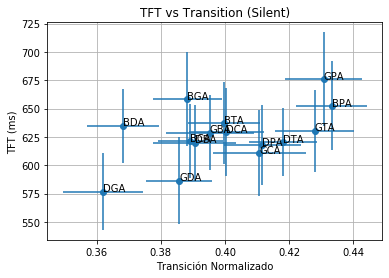

In [114]:
y      = StatsOcular[StatsOcular.block==2].TFT['mean']      # Silencio
y_err  = StatsOcular[StatsOcular.block==2].TFT['sem']  
x      = StatsOcular[StatsOcular.block==1].NormTransition['mean']
x_err  = StatsOcular[StatsOcular.block==1].NormTransition['sem']
labels = StatsOcular[StatsOcular.block==1].index.levels[0]
plt.errorbar(x, y, yerr=y_err, xerr=x_err, fmt= 'o')

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 

plt.title('TFT vs Transition (Silent)')
plt.ylabel('TFT (ms)')
plt.xlabel('Transición Normalizado')
for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))

plt.grid()
plt.show()

# FPRT

### Silent vs Aloud

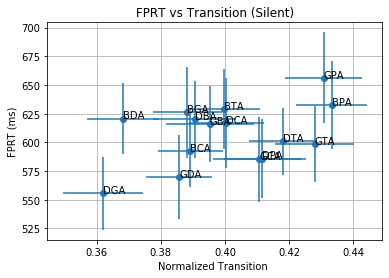

In [117]:
y      = StatsOcular[StatsOcular.block==2].FPRT['mean']      # Silent
y_err  = StatsOcular[StatsOcular.block==2].FPRT['sem']  
x      = StatsOcular[StatsOcular.block==1].NormTransition['mean']
x_err  = StatsOcular[StatsOcular.block==1].NormTransition['sem']
labels = StatsOcular[StatsOcular.block==1].index.levels[0]
plt.errorbar(x, y, yerr=y_err, xerr=x_err, fmt= 'o')

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 

plt.title('FPRT vs Transition (Silent)')
plt.ylabel('FPRT (ms)')
plt.xlabel('Normalized Transition ')
for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))

plt.grid()
plt.show()

### Statistical tests of groups

In [119]:
# Second voiced plosive test
unvoiced = OcularData[OcularData.SegConsVoceada==0].NormTransition
voiced   = OcularData[OcularData.SegConsVoceada==1].NormTransition

print('mean of second voiced plosive group is ' + str(np.mean(voiced)))
print('standard error of second voiced plosive group is ' + str(np.std(voiced)/np.sqrt(len(voiced))))
print('mean of second unvoiced plosive group is ' + str(np.mean(unvoiced)))
print('standard error of second voiced plosive group is ' + str(np.std(unvoiced)/np.sqrt(len(unvoiced))))
scipy.stats.ttest_ind(voiced.values[np.isfinite(voiced.values)], unvoiced.values[np.isfinite(unvoiced.values)])

print(len(voiced.values[np.isfinite(voiced.values)]) + len(unvoiced.values[np.isfinite(unvoiced.values)]))


mean of second voiced plosive group is 0.38171262928056404
standard error of second voiced plosive group is 0.0028099413806033776
mean of second unvoiced plosive group is 0.41291797422561843
standard error of second voiced plosive group is 0.002255977771880121
726


In [120]:
# Simmetry tests

lista1 = ['BDA', 'BGA', 'DGA']
lista2 = ['DBA', 'GBA', 'GDA']

index1 = []
for i,ccv in enumerate(OcularData.CCV):
    if ccv in lista1:
        index1.append(i)
index2 = []
for i,ccv in enumerate(OcularData.CCV):
    if ccv in lista2:
        index2.append(i)

x = OcularData.NormTransition.iloc[index1]
y = OcularData.NormTransition.iloc[index2]
x = x.values[np.isfinite(x.values)]
y = y.values[np.isfinite(y.values)]
print('mean of first simmetry group is ' + str(x.mean()))
print('standard error of first simmetry group is ' + str((x.std()/np.sqrt(len(x)))))
print('mean of second simmetry group is ' + str(y.mean()))
print('standard error of second simmetry group is ' + str((y.std()/np.sqrt(len(y)))))

scipy.stats.ttest_ind(y,x)
len(x)+ len(y)

mean of first simmetry group is 0.3726317969688251
standard error of first simmetry group is 0.0066834523679135
mean of second simmetry group is 0.39011853486643056
standard error of second simmetry group is 0.006998592842214748


285